<a href="https://colab.research.google.com/github/Abby-Wale/CNN_For_Dementia/blob/main/s247172_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade --quiet


In [ ]:
import opendatasets as od
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import math
import shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from PIL import Image
import torchvision
from torchvision import models
from torch.autograd import Variable
import torch.optim as optim
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score
import pandas as pd
import torchvision.models as models
from torchvision.transforms import ToTensor
from torch.optim import Adam
import time

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset/download?datasetVersionNumber=1'
od.download(dataset_url)

100%|██████████| 28.0M/28.0M [00:00<00:00, 102MB/s] 


In [ ]:
dementia_data = '/content/alzheimer-mri-dataset/Dataset'

In [ ]:
for cls in os.listdir(dementia_data):
    print(cls, ':', len(os.listdir(dementia_data + '/' + cls)))

Non_Demented : 3200
Mild_Demented : 896
Moderate_Demented : 64
Very_Mild_Demented : 2240


In [ ]:
num_img = {}
for dir in os.listdir(dementia_data):
  num_img[dir] = len(os.listdir(os.path.join(dementia_data,dir)))

num_img.items()

def datafolder(folder, split):
    base_path = os.path.dirname(dementia_data)
    folder_path = os.path.join(base_path, folder)
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        for dir in os.listdir(dementia_data):
            os.makedirs(os.path.join(folder_path, dir))
            for img in np.random.choice(a=os.listdir(os.path.join(dementia_data, dir)), size=(math.floor(split * num_img[dir]) - 5), replace=False):
                O = os.path.join(dementia_data, dir, img)
                D = os.path.join(folder_path, dir)
                shutil.copy(O, D)
                os.remove(O)
    else:
        print('the folder exists')

In [ ]:
datafolder('train', 0.6)
datafolder('val', 0.2)
datafolder('test', 0.2)

In [ ]:
train_dataset = '/content/alzheimer-mri-dataset/train'
val_dataset = '/content/alzheimer-mri-dataset/val'
test_dataset = '/content/alzheimer-mri-dataset/test'

In [ ]:
# before augmenting the training dataset

data = []
for cls in os.listdir(train_dataset):
    subdir_path = os.path.join(train_dataset, cls)
    file_count = len(os.listdir(subdir_path))
    data.append((cls, file_count))
df = pd.DataFrame(data, columns=['Class', 'Image Count'])
print(df)

train_ds = ImageFolder(train_dataset)
train_count = len(train_ds)
print('Length of the dataset')
print('Length of Training Dataset:',  len(train_ds))

                Class  Image Count
0        Non_Demented         1915
1       Mild_Demented          532
2   Moderate_Demented           33
3  Very_Mild_Demented         1339
Length of the dataset
Length of Training Dataset: 3819


In [ ]:
# augmenting the training data


data_transforms = tt.Compose([
    tt.RandomRotation(10),
    tt.RandomHorizontalFlip(),
    tt.RandomVerticalFlip()])


data_dir = '/content/alzheimer-mri-dataset/train'


dataset = ImageFolder(root=data_dir, transform=data_transforms)


desired_num_images = {
    'Very_Mild_Demented': 2500,
    'Non_Demented': 2500,
    'Mild_Demented': 1500,
    'Moderate_Demented': 200
}


augmented_images = {c: [] for c in dataset.classes}


for image, label in dataset:
    class_label = dataset.classes[label]
    if len(augmented_images[class_label]) < desired_num_images[class_label]:
        augmented_images[class_label].append(image)


        if len(augmented_images[class_label]) < desired_num_images[class_label]:
            augmented_images[class_label].append(data_transforms(image))


new_data_dir = 'new_train_set'
os.makedirs(new_data_dir, exist_ok=True)


for c in dataset.classes:
    class_dir = os.path.join(new_data_dir, c)
    os.makedirs(class_dir, exist_ok=True)

    random.shuffle(augmented_images[c])


    for i in range(desired_num_images[c]):
        if i < len(augmented_images[c]):
            image = augmented_images[c][i]
            filename = os.path.join(class_dir, f"{c}_{i}.jpg")
            image.save(filename)



    while len(augmented_images[c]) < desired_num_images[c]:
        random_image = random.choice(augmented_images[c])
        filename = os.path.join(class_dir, f"{c}_{len(augmented_images[c])}.jpg")
        random_image.save(filename)
        augmented_images[c].append(random_image)


In [ ]:
# after augmenting the training dataset

train_dataset =  '/content/new_train_set'

data = []
for cls in os.listdir(train_dataset):
    subdir_path = os.path.join(train_dataset, cls)
    file_count = len(os.listdir(subdir_path))
    data.append((cls, file_count))
df = pd.DataFrame(data, columns=['Class', 'Image Count'])
print(df)

train_ds = ImageFolder(train_dataset)
train_count = len(train_ds)
print('Length of the dataset')
print('Length of Training Dataset:',  len(train_ds))

                Class  Image Count
0        Non_Demented         2500
1       Mild_Demented         1500
2   Moderate_Demented          200
3  Very_Mild_Demented         2500
Length of the dataset
Length of Training Dataset: 6700


In [ ]:

# validation data
data = []
for cls in os.listdir(val_dataset):
    subdir_path = os.path.join(val_dataset, cls)
    file_count = len(os.listdir(subdir_path))
    data.append((cls, file_count))
df = pd.DataFrame(data, columns=['Class', 'Image Count'])
print(df)

valid_ds = ImageFolder(val_dataset)
print('Length of the dataset')
valid_count = len(valid_ds)
print('Lenght of Validation Dataset:',  len(valid_ds))

                Class  Image Count
0        Non_Demented          635
1       Mild_Demented          174
2   Moderate_Demented            7
3  Very_Mild_Demented          443
Length of the dataset
Lenght of Validation Dataset: 1259


In [ ]:
# test data
data = []
for cls in os.listdir(test_dataset):
    subdir_path = os.path.join(test_dataset, cls)
    file_count = len(os.listdir(subdir_path))
    data.append((cls, file_count))
df = pd.DataFrame(data, columns=['Class', 'Image Count'])
print(df)

test_ds = ImageFolder(test_dataset)
print('Length of the dataset')
test_count = len(valid_ds)
print('Lenght of Test Dataset:',  len(test_ds))

                Class  Image Count
0        Non_Demented          635
1       Mild_Demented          174
2   Moderate_Demented            7
3  Very_Mild_Demented          443
Length of the dataset
Lenght of Test Dataset: 1259


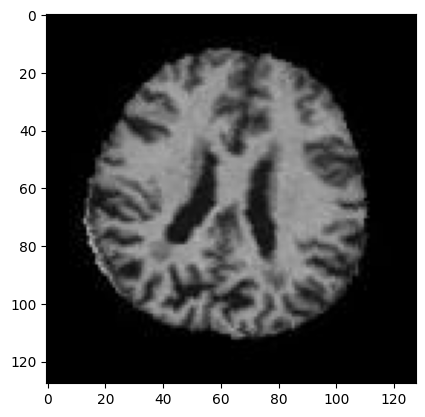

In [ ]:
img, label = train_ds[120]
plt.imshow(img)

In [ ]:
train_ds = ImageFolder(train_dataset, tt.ToTensor())
means = []
stdevs = []
for img, label in train_ds:
    means.append(np.mean(img.numpy(), axis=(1,2)))
    stdevs.append(np.std(img.numpy(), axis=(1,2)))
means = np.mean(means, axis=0)
stdevs = np.mean(stdevs, axis=0)
stats = (means.tolist(), stdevs.tolist())


train_ds = ImageFolder(train_dataset, tt.Compose([tt.RandomHorizontalFlip(),  
                                                  tt.Resize(64), 
                                                  tt.RandomRotation(45), 
                                                  tt.ToTensor(), 
                                                  tt.Normalize(*stats)]))

valid_ds = ImageFolder(train_dataset, tt.Compose([tt.RandomHorizontalFlip(),  
                                                  tt.Resize(64), 
                                                  tt.RandomRotation(45), 
                                                  tt.ToTensor(), 
                                                  tt.Normalize(*stats)]))

test_ds = ImageFolder(train_dataset, tt.Compose([tt.Resize(64),
                                                  tt.ToTensor(), 
                                                  tt.Normalize(*stats)]))

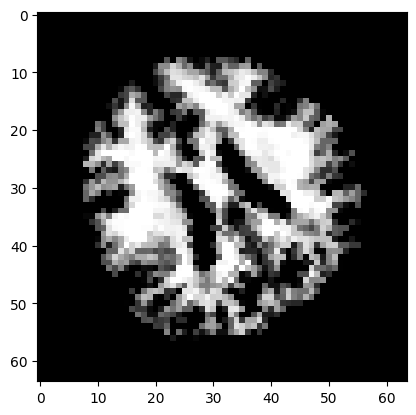

In [ ]:
'''image in index 120 after normalization'''
img, label = train_ds[120]
plt.imshow(img.permute((1, 2, 0)))

In [ ]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=64)


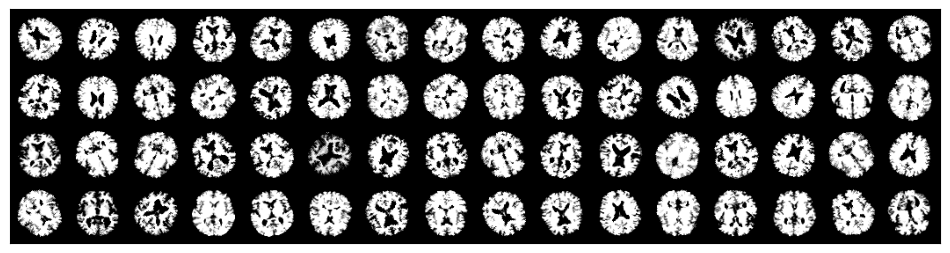

In [ ]:

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

In [ ]:
"""this block helps choose the available accelerator"""

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, model_name, num_classes=4):
        super(ResNet18, self).__init__()
        self.model_name = model_name
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        
        for _ in range(1, num_blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:

class AlexNet(nn.Module):
    def __init__(self, model_name, num_classes=4):
        super(AlexNet, self).__init__()
        self.model_name = model_name
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, input):
        output = self.features(input)
        output = self.avgpool(output)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)
        return output


In [ ]:

class VGG(nn.Module):
    def __init__(self, model_name, num_classes=4):
        super(VGG, self).__init__()
        self.model_name = model_name
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),  # Adjusted input size to match the size of the input tensor
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


Weight decay, also known as L2 regularization, is a technique used during training to prevent overfitting in machine learning models. It is a form of regularization that adds a penalty term to the loss function, encouraging the model to learn smaller weights.
checck out what dropout does and other regularization techniques


In [ ]:
def evaluate_model(model, train_dl, valid_dl, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)
    num_epochs = 100

    train_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0.0
    best_model_state = None

    start_time = time.time()

    model_name = model.model_name  # Get the model name from the ModelBuilder instance

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_dl:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = train_correct / train_total
        train_losses.append(train_loss / len(train_dl))
        train_accuracies.append(train_accuracy)

        model.eval()
        with torch.no_grad():
            val_correct = 0
            val_total = 0

            for images, labels in valid_dl:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs, dim=1)

                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

            val_accuracy = val_correct / val_total
            val_accuracies.append(val_accuracy)

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model_state = model.state_dict()

        torch.save(best_model_state, f'{model_name}_best_model.pth')

        print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss / len(train_dl):.4f} - Train Accuracy: {train_accuracy:.4f} - Validation Accuracy: {val_accuracy:.4f}')

    end_time = time.time()
    total_run_time = end_time - start_time
    print(f'Total Run Time: {total_run_time:.2f} seconds')

    return train_losses, train_accuracies, val_accuracies, num_epochs


In [ ]:
# to test the best saved model

def test_model(model, test_dl, device):
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_dl:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)

            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    print(f'Test Accuracy: {test_accuracy:.4f}')



In [ ]:
def plot_curves(train_losses, train_accuracies, val_accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import warnings

def visualize_predictions(model, data_loader, device, class_names, grid_x, grid_y):
    num_images = grid_x * grid_y
    plt.figure(figsize=(10, 10))
    model.eval()

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            if i >= num_images:
                break
            
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            img = images[0].permute(1, 2, 0).cpu().numpy()

            # Normalize image data
            img = (img - np.min(img)) / (np.max(img) - np.min(img))

            plt.subplot(grid_x, grid_y, i + 1)
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning)
                plt.imshow(img)
            
            if preds[0].item() == labels[0].item():
                xlabel_color = 'green'
                ylabel_color = 'green'
            else:
                xlabel_color = 'red'
                ylabel_color = 'red'
            
            predicted_class = class_names[preds[0].item()]
            true_class = class_names[labels[0].item()]

            plt.xlabel(predicted_class, color=xlabel_color, fontsize=5)
            plt.ylabel(true_class, color=ylabel_color, fontsize=5)
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            plt.axis('on')

            if i == num_images - 1:
                break

    plt.tight_layout()
    plt.show()



In [ ]:


def generate_confusion_matrix(model, data_loader, device, num_classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    confusion_mat = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return confusion_mat


In [ ]:
def display_confusion_matrix(confusion_mat, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_mat, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(confusion_mat[i, j]), ha='center', va='center', color='white' if confusion_mat[i, j] > confusion_mat.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()



In [ ]:
def calculate_metrics(confusion_mat):
    tp = np.diag(confusion_mat)
    fp = np.sum(confusion_mat, axis=0) - tp
    fn = np.sum(confusion_mat, axis=1) - tp
    tn = np.sum(confusion_mat) - (tp + fp + fn)

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)

    return accuracy, precision, recall, f1_score


In [ ]:
def generate_confusion_matrix_with_metrics(model, data_loader, device, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        confusion_mat = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
        accuracy, precision, recall, f1_score = calculate_metrics(confusion_mat)

        print("Confusion Matrix:")
        print(confusion_mat)
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-Score:", f1_score)


In [ ]:
test_ds_path = '/content/alzheimer-mri-dataset/test'
grid_x = 5
grid_y = 5
class_names = test_ds.classes
num_epochs = 30
data_loader = test_dl
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4


Precision: TP / (TP + FP)
Accuracy: (TP + TN) / (TP + TN + FP + FN)
Recall: TP / (TP + FN)
F1 score: 2 * (Precision * Recall) / (Precision + Recall)

Epoch 1/100 - Train Loss: 1.1247 - Train Accuracy: 0.4482 - Validation Accuracy: 0.5042
Epoch 2/100 - Train Loss: 1.0451 - Train Accuracy: 0.4954 - Validation Accuracy: 0.5164
Epoch 3/100 - Train Loss: 1.0115 - Train Accuracy: 0.5194 - Validation Accuracy: 0.5276
Epoch 4/100 - Train Loss: 0.9932 - Train Accuracy: 0.5339 - Validation Accuracy: 0.5304
Epoch 5/100 - Train Loss: 0.9822 - Train Accuracy: 0.5372 - Validation Accuracy: 0.5469
Epoch 6/100 - Train Loss: 0.9703 - Train Accuracy: 0.5397 - Validation Accuracy: 0.5507
Epoch 7/100 - Train Loss: 0.9453 - Train Accuracy: 0.5488 - Validation Accuracy: 0.5542
Epoch 8/100 - Train Loss: 0.9323 - Train Accuracy: 0.5570 - Validation Accuracy: 0.5578
Epoch 9/100 - Train Loss: 0.9117 - Train Accuracy: 0.5700 - Validation Accuracy: 0.5284
Epoch 10/100 - Train Loss: 0.8987 - Train Accuracy: 0.5697 - Validation Accuracy: 0.5930
Epoch 11/100 - Train Loss: 0.8743 - Train Accuracy: 0.5855 - Validation Accuracy: 0.5513
Epoch 12/100 - Train Loss: 0.8

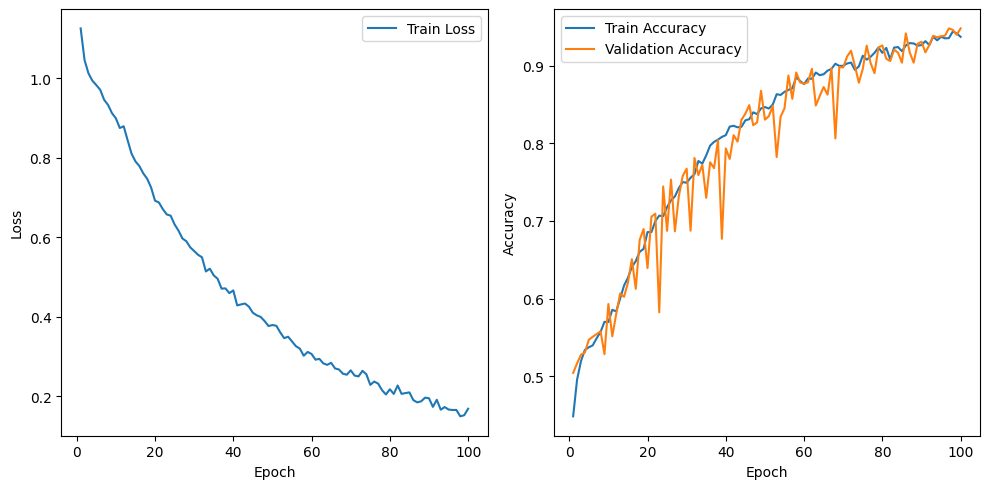

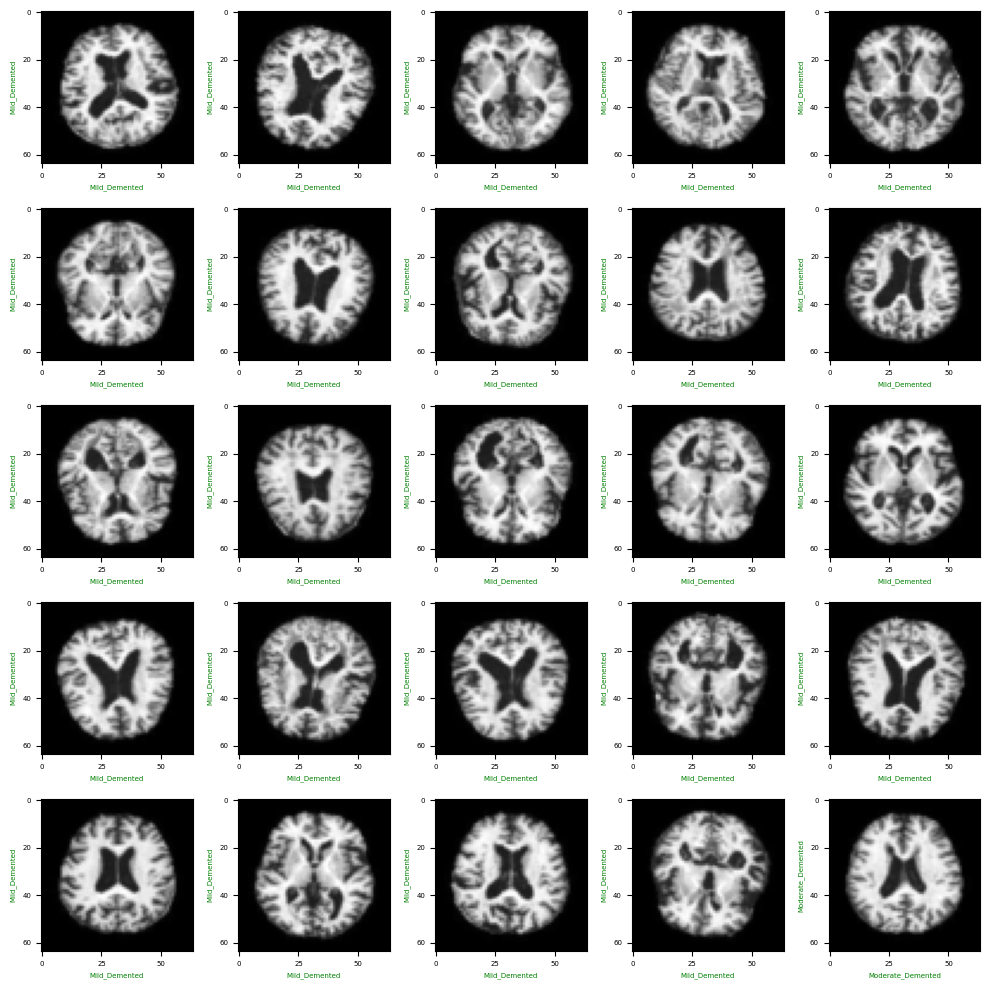

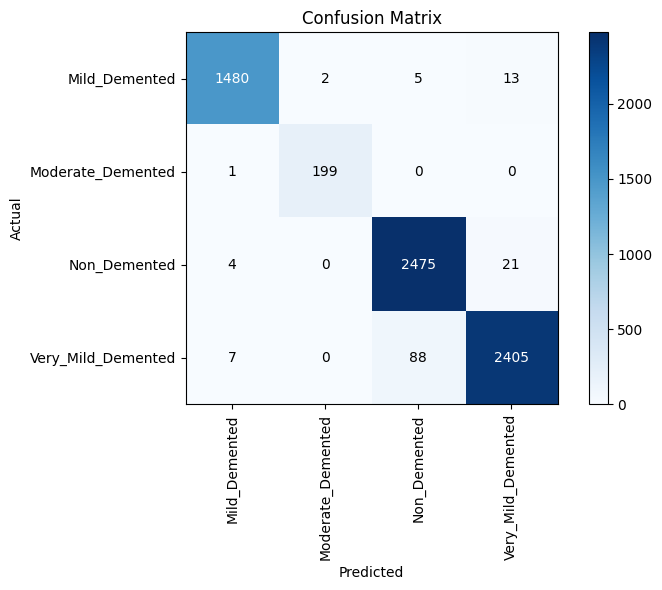


Confusion Matrix:
[[1480    2    5   13]
 [   1  199    0    0]
 [   4    0 2475   21]
 [   7    0   88 2405]]
Accuracy: [0.99522388 0.99955224 0.98238806 0.98074627]
Precision: [0.9919571  0.99004975 0.96378505 0.98605986]
Recall: [0.98666667 0.995      0.99       0.962     ]
F1-Score: [0.98930481 0.9925187  0.97671665 0.97388135]


In [ ]:
model = VGG('vgg', num_classes=4)


model = model.to(device)

train_losses, train_accuracies, val_accuracies, num_epochs = evaluate_model(model, train_dl, valid_dl, device)
print()

plot_curves(train_losses, train_accuracies, val_accuracies, num_epochs)
print()

best_model_state = torch.load('/content/vgg_best_model.pth')

model = VGG('vgg', num_classes)

model.load_state_dict(best_model_state)

model.to(device)
model.eval()

'''The model is set to evaluation mode (model.eval()) to disable dropout or batch normalization layers' training behavior.'''

visualize_predictions(model, data_loader, device, class_names, grid_x, grid_y)
print()
confusion_mat = generate_confusion_matrix(model, data_loader, device, num_classes)
display_confusion_matrix(confusion_mat, class_names)
print()
generate_confusion_matrix_with_metrics(model, data_loader, device, num_classes)


In the provided result, we have information about the training accuracy, loss, and validation accuracy at each epoch during the training process. Here's how we can interpret the information:

1. Training Accuracy: It represents the accuracy of the model on the training dataset. It shows how well the model is performing on the data it has been trained on. In the given result, the training accuracy starts at 44.82% in the first epoch and gradually improves over time, reaching 93.57% in the 97th epoch.

2. Loss: It is a measure of how well the model is able to approximate the correct output. The lower the loss, the better the model's performance. In this case, the training loss starts at 1.1247 in the first epoch and decreases with each epoch, reaching 0.1656 in the 97th epoch. This indicates that the model is improving in terms of minimizing the difference between predicted and actual outputs.

3. Validation Accuracy: It represents the accuracy of the model on a separate validation dataset that was not used during training. It serves as an estimate of how well the model will perform on unseen data. In the given result, the validation accuracy starts at 50.42% in the first epoch and gradually improves, reaching 94.82% in the 97th epoch.

The use of saving the best model is to keep track of the model with the best performance on the validation set. During the training process, the model's performance on the validation set is monitored, and if a new best validation accuracy is achieved, the model weights are saved. This ensures that we have the best-performing model at hand, which can be used for future predictions or as a checkpoint for further training. By saving the best model, we avoid overfitting and have a model that generalizes well to unseen data.

Epoch 1/100 - Train Loss: 1.2113 - Train Accuracy: 0.3740 - Validation Accuracy: 0.3731
Epoch 2/100 - Train Loss: 1.1756 - Train Accuracy: 0.3760 - Validation Accuracy: 0.4273
Epoch 3/100 - Train Loss: 1.1409 - Train Accuracy: 0.4370 - Validation Accuracy: 0.4460
Epoch 4/100 - Train Loss: 1.0648 - Train Accuracy: 0.4824 - Validation Accuracy: 0.4888
Epoch 5/100 - Train Loss: 1.0500 - Train Accuracy: 0.4878 - Validation Accuracy: 0.4925
Epoch 6/100 - Train Loss: 1.0427 - Train Accuracy: 0.4900 - Validation Accuracy: 0.4954
Epoch 7/100 - Train Loss: 1.0355 - Train Accuracy: 0.4960 - Validation Accuracy: 0.5033
Epoch 8/100 - Train Loss: 1.0301 - Train Accuracy: 0.5009 - Validation Accuracy: 0.4990
Epoch 9/100 - Train Loss: 1.0284 - Train Accuracy: 0.4960 - Validation Accuracy: 0.4966
Epoch 10/100 - Train Loss: 1.0275 - Train Accuracy: 0.5010 - Validation Accuracy: 0.5137
Epoch 11/100 - Train Loss: 1.0183 - Train Accuracy: 0.5031 - Validation Accuracy: 0.5009
Epoch 12/100 - Train Loss: 1.0

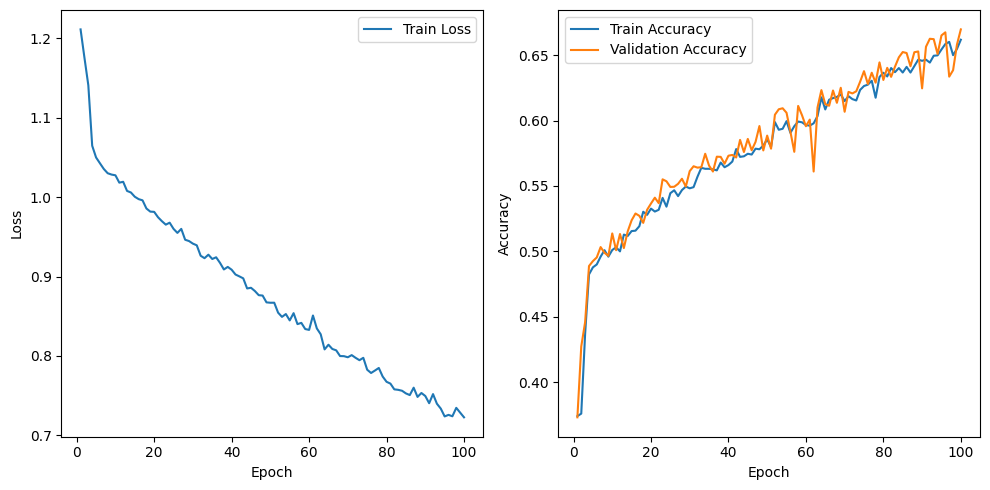

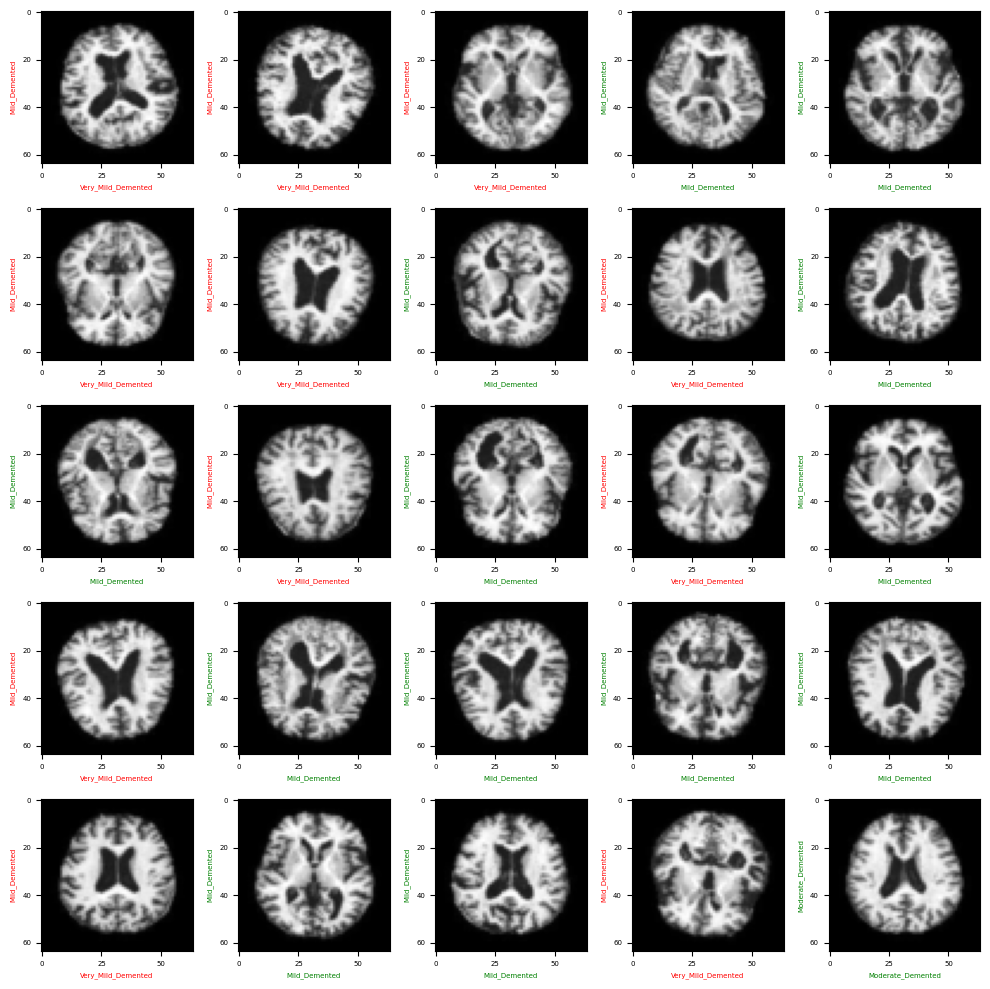

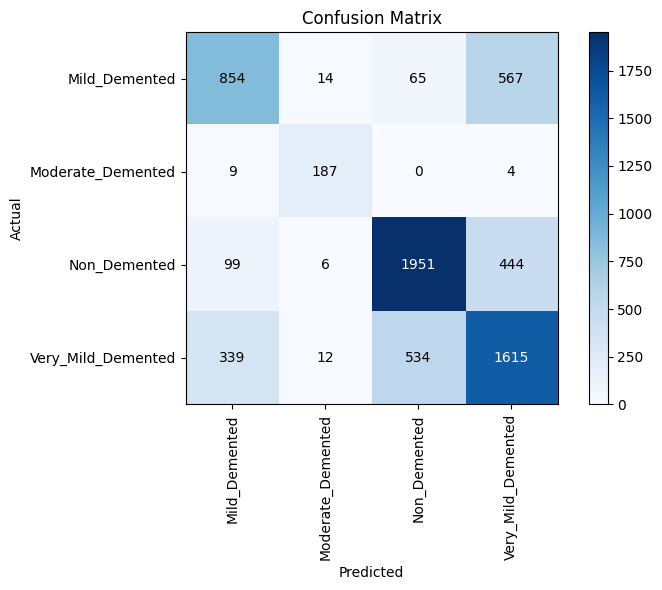


Confusion Matrix:
[[ 854   14   65  567]
 [   9  187    0    4]
 [  99    6 1951  444]
 [ 339   12  534 1615]]
Accuracy: [0.83686567 0.99328358 0.82865672 0.71641791]
Precision: [0.65641814 0.85388128 0.76509804 0.61406844]
Recall: [0.56933333 0.935      0.7804     0.646     ]
F1-Score: [0.60978222 0.89260143 0.77267327 0.62962963]


In [ ]:
model = AlexNet('alexnet', num_classes=4)


model = model.to(device)

train_losses, train_accuracies, val_accuracies, num_epochs = evaluate_model(model, train_dl, valid_dl, device)
print()

plot_curves(train_losses, train_accuracies, val_accuracies, num_epochs)
print()

best_model_state = torch.load('/content/alexnet_best_model.pth')

model = AlexNet('alexnet', num_classes)

model.load_state_dict(best_model_state)

model.to(device)
model.eval()
visualize_predictions(model, data_loader, device, class_names, grid_x, grid_y)
print()
confusion_mat = generate_confusion_matrix(model, data_loader, device, num_classes)
display_confusion_matrix(confusion_mat, class_names)
print()
generate_confusion_matrix_with_metrics(model, data_loader, device, num_classes)


In the given result, we can see the training accuracy, loss, and validation accuracy for each epoch during the training process of a model. Here's an explanation of the different metrics and the use of saving the best model:

1. Training Accuracy: It represents the accuracy of the model on the training data. It shows how well the model is able to classify or predict the correct labels for the training examples. In this case, the training accuracy starts at around 0.37 and gradually improves with each epoch, reaching 0.66 by the end of training. This suggests that the model is learning from the training data and improving its performance.

2. Loss: It indicates the error or the dissimilarity between the predicted output and the actual output. The training loss is calculated during each epoch based on the model's predictions and the true labels of the training data. A lower loss value indicates that the model's predictions are closer to the actual labels. In this case, the training loss decreases from 1.21 in the first epoch to 0.72 in the last epoch, which suggests that the model is reducing its error and improving its predictions.

3. Validation Accuracy: It measures the accuracy of the model on a separate validation dataset that is not used for training. The validation accuracy helps us understand how well the model generalizes to new, unseen data. In this case, the validation accuracy starts at around 0.37 and improves with each epoch, reaching 0.67 at the end of training. This indicates that the model is also performing well on the validation data and is generalizing effectively.

The "saving best model" refers to a technique where the model's weights or parameters are saved during training when the validation accuracy is the highest or when the validation loss is the lowest. This technique is used to prevent overfitting and to capture the best-performing model during the training process. By saving the best model, we can later use it for evaluation or prediction on new, unseen data, ensuring that we have the most accurate and well-performing version of the model.

Epoch 1/100 - Train Loss: 1.3432 - Train Accuracy: 0.3216 - Validation Accuracy: 0.4931
Epoch 2/100 - Train Loss: 1.1621 - Train Accuracy: 0.5049 - Validation Accuracy: 0.5222
Epoch 3/100 - Train Loss: 1.0822 - Train Accuracy: 0.5251 - Validation Accuracy: 0.5451
Epoch 4/100 - Train Loss: 1.0419 - Train Accuracy: 0.5339 - Validation Accuracy: 0.5478
Epoch 5/100 - Train Loss: 1.0109 - Train Accuracy: 0.5540 - Validation Accuracy: 0.5546
Epoch 6/100 - Train Loss: 0.9864 - Train Accuracy: 0.5528 - Validation Accuracy: 0.5678
Epoch 7/100 - Train Loss: 0.9662 - Train Accuracy: 0.5625 - Validation Accuracy: 0.5694
Epoch 8/100 - Train Loss: 0.9593 - Train Accuracy: 0.5631 - Validation Accuracy: 0.5782
Epoch 9/100 - Train Loss: 0.9434 - Train Accuracy: 0.5663 - Validation Accuracy: 0.5763
Epoch 10/100 - Train Loss: 0.9299 - Train Accuracy: 0.5778 - Validation Accuracy: 0.5873
Epoch 11/100 - Train Loss: 0.9181 - Train Accuracy: 0.5827 - Validation Accuracy: 0.5872
Epoch 12/100 - Train Loss: 0.9

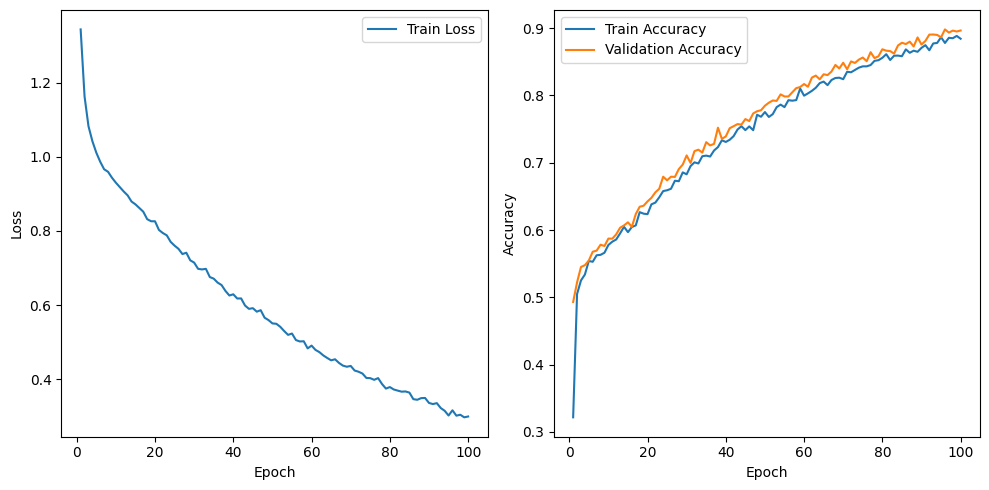

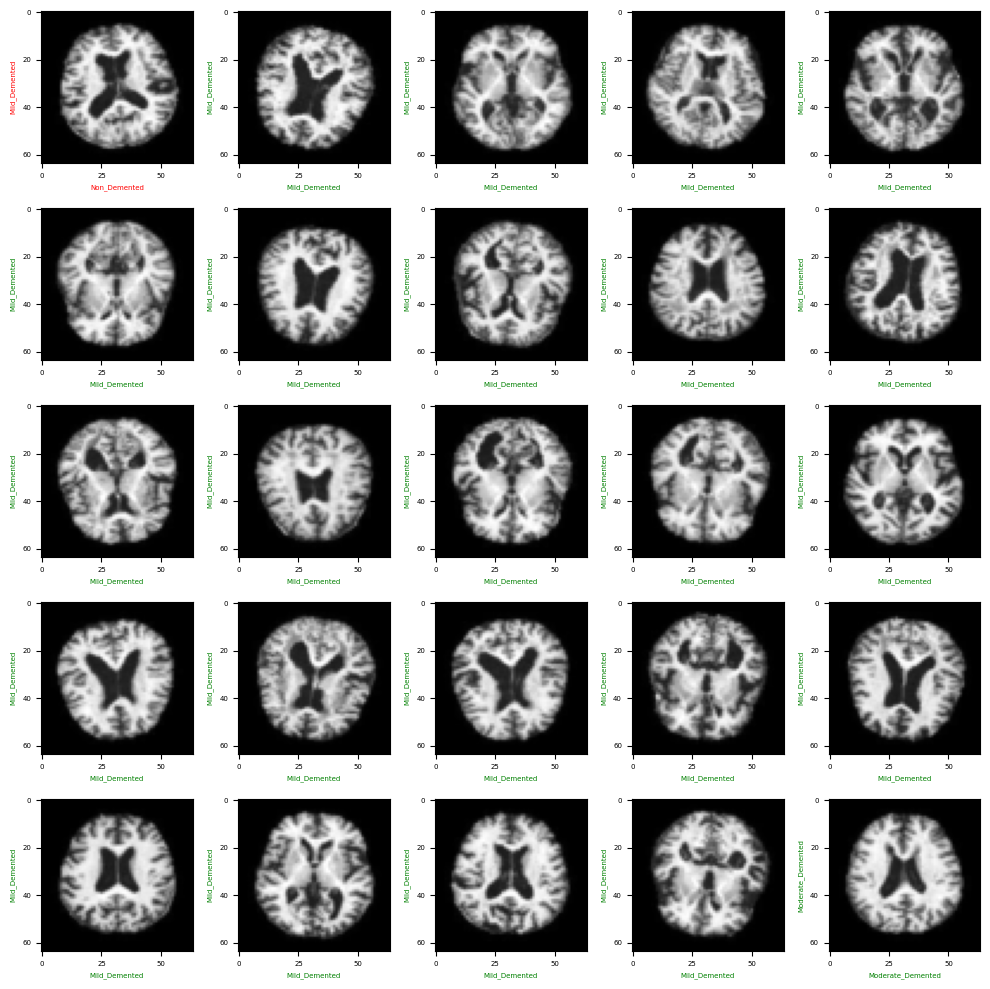

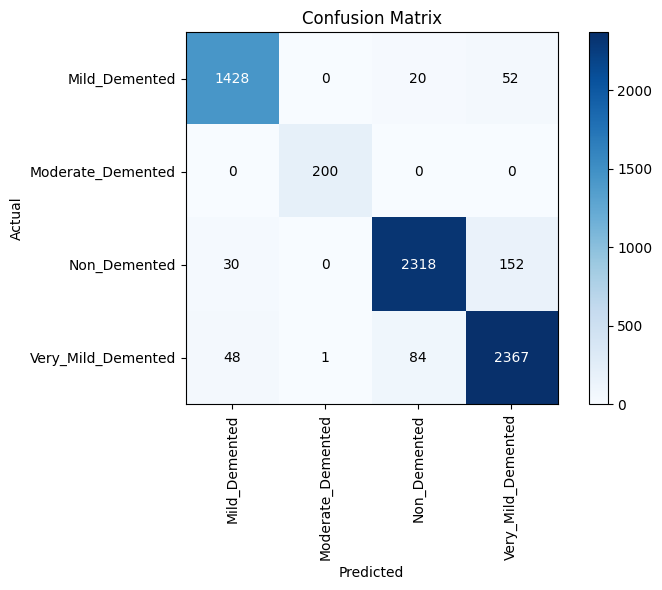


Confusion Matrix:
[[1428    0   20   52]
 [   0  200    0    0]
 [  30    0 2318  152]
 [  48    1   84 2367]]
Accuracy: [0.97761194 0.99985075 0.95731343 0.94970149]
Precision: [0.94820717 0.99502488 0.95706028 0.92065344]
Recall: [0.952  1.     0.9272 0.9468]
F1-Score: [0.9500998  0.99750623 0.94189354 0.93354368]


In [ ]:
model = ResNet18('resnet', num_classes=4)


model = model.to(device)

train_losses, train_accuracies, val_accuracies, num_epochs = evaluate_model(model, train_dl, valid_dl, device)
print()

plot_curves(train_losses, train_accuracies, val_accuracies, num_epochs)
print()

best_model_state = torch.load('/content/resnet_best_model.pth')

model = ResNet18('resnet', num_classes)

model.load_state_dict(best_model_state)

model.to(device)
model.eval()
visualize_predictions(model, data_loader, device, class_names, grid_x, grid_y)
print()
confusion_mat = generate_confusion_matrix(model, data_loader, device, num_classes)
display_confusion_matrix(confusion_mat, class_names)
print()
generate_confusion_matrix_with_metrics(model, data_loader, device, num_classes)


In the provided result, we have the training accuracy, training loss, and validation accuracy for each epoch of a model training process. Let's analyze the information and explain the concepts involved.

Training Accuracy:
The training accuracy indicates the percentage of correctly predicted labels by the model on the training dataset. It represents how well the model is performing on the data it was trained on. In the given result, the training accuracy starts at a relatively low value of 0.3216 in the first epoch and gradually improves over time, reaching 0.8857 in the 97th epoch.

Training Loss:
The training loss represents the error or mismatch between the predicted labels and the actual labels in the training dataset. It is a measure of how well the model is fitting the training data. Lower values indicate better performance, as they represent smaller errors. In the given result, the training loss starts at a higher value of 1.3432 in the first epoch and consistently decreases over the epochs, indicating that the model is learning and reducing its error.

Validation Accuracy:
The validation accuracy measures the performance of the model on a separate validation dataset that was not used during training. It provides an estimate of how well the model will generalize to unseen data. In the given result, the validation accuracy starts at 0.4931 in the first epoch and improves over time, reaching 0.8934 in the 97th epoch.

Saving the Best Model:
The concept of saving the best model involves keeping track of the model's performance during training and saving the model parameters when it achieves the best validation accuracy or the lowest validation loss. By saving the best model, we can ensure that we have a checkpoint of the model that performed the best on the validation dataset. This is useful because training a model involves multiple epochs, and we might observe fluctuations in the validation accuracy or loss. Saving the best model allows us to use it later for inference or as a starting point for further training, rather than using a model from an earlier epoch that may not have performed as well.

In the given result, it does not mention explicitly whether the best model is being saved. However, if the best model is being saved, it would typically be based on the validation accuracy or loss. Saving the best model ensures that we have the most optimal model parameters based on the validation performance, which can lead to better results when using the model for predictions on new data.

Comparing the results of ResNet, AlexNet, and VGG, we can observe the following:

1. Accuracy:
   - ResNet: The accuracy values for the four classes are 0.978, 1.000, 0.957, and 0.950, respectively.
   - AlexNet: The accuracy values for the four classes are 0.837, 0.993, 0.829, and 0.716, respectively.
   - VGG: The accuracy values for the four classes are 0.995, 0.999, 0.982, and 0.981, respectively.

   Based on accuracy, VGG performs the best, followed by ResNet and then AlexNet.

2. Precision:
   - ResNet: The precision values for the four classes are 0.948, 0.995, 0.957, and 0.921, respectively.
   - AlexNet: The precision values for the four classes are 0.656, 0.854, 0.765, and 0.614, respectively.
   - VGG: The precision values for the four classes are 0.992, 0.990, 0.964, and 0.986, respectively.

   VGG achieves the highest precision values for all classes, indicating better performance in correctly identifying true positives.

3. Recall:
   - ResNet: The recall values for the four classes are 0.952, 1.000, 0.927, and 0.947, respectively.
   - AlexNet: The recall values for the four classes are 0.569, 0.935, 0.780, and 0.646, respectively.
   - VGG: The recall values for the four classes are 0.987, 0.995, 0.990, and 0.962, respectively.

   VGG achieves the highest recall values for all classes, indicating better performance in correctly identifying true positives.

4. F1-Score:
   - ResNet: The F1-score values for the four classes are 0.950, 0.998, 0.942, and 0.934, respectively.
   - AlexNet: The F1-score values for the four classes are 0.610, 0.893, 0.773, and 0.630, respectively.
   - VGG: The F1-score values for the four classes are 0.989, 0.993, 0.977, and 0.974, respectively.

   VGG achieves the highest F1-score values for all classes, indicating better overall performance in terms of precision and recall.

In summary, based on the provided results, VGG generally outperforms both ResNet and AlexNet in terms of accuracy, precision, recall, and F1-score. ResNet shows competitive performance, while AlexNet performs relatively worse compared to the other two models.